In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import re

from pycparser.c_ast import TypeDecl, ArrayDecl
from pycparser import c_ast

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

# Load Data

In [ ]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

# Allowed var names

In [ ]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

In [ ]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'default',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf',
    'cos',
    'malloc'
]


def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

In [ ]:
embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

In [ ]:
embedding_map

# Var replace functions

In [ ]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

# Closest Var functions

In [ ]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    closest_i = 0
#     closest_dist = l2_norm(embedding_map[closest_i], embedding)
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
#         d = l2_norm(embedding_map[i], embedding)
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Grad locating functions

In [ ]:
def get_embedding(indices, node_list):
    '''
    get the embeddings at the index positions in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    '''
    
    '''
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

def get_grad(x, var_index, node_list):
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, var_index, [], 0)
        grads += get_embedding(indices, node_list.grad[:, i, :])
        try:
            node_embedding = get_embedding(indices, node_list[:, i, :])[0]
        except Exception as e:
#             print(e)
            pass
        
    if len(grads) < 1:
        return None, None
    grad = torch.stack(grads).sum(dim=0)
    return grad, node_embedding

# Var name finder

In [ ]:

class declarationFinder(c_ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    
    def visit_Decl(self, node):
        if type(node.type) in [TypeDecl, ArrayDecl] :
            self.names.add(node.name)

def get_var_names(ast):
    declaration_finder = declarationFinder()
    declaration_finder.visit(ast)
    return declaration_finder.names
    
# get_var_names(x)

# FGSM

In [ ]:
def gradient_method(x, grad, node_embedding, n_list, var, epsilon, metric):

    orig_index = vocab[var].index if var in vocab else MAX_TOKEN

#     grad, node_embedding = get_grad(x, orig_index, n_list)
    if grad is None:
#         print("no leaf occurences")
        return None

    v = node_embedding.detach().numpy()
    g = torch.sign(grad).detach().numpy()

    v = v + epsilon * g
    # get the closest emebedding from our map
    i = closest_index(v, embedding_map, metric)
#         print("orig name:", word2vec.index2word[orig_index], "; new name:", word2vec.index2word[i])
    if i != orig_index:
        return replace_var(x, orig_index, i)
    else:
        return x

In [ ]:

# x, ast = block_data['code'][45281], ast_data['code'][45281]

# _, orig_pred = torch.max(model([x]).data, 1)
# orig_pred = orig_pred.item()

# # get the grad
# loss_function = torch.nn.CrossEntropyLoss()
# labels = torch.LongTensor([orig_pred])
# output = model([x])
# loss = loss_function(output, Variable(labels))
# loss.backward()
# n_list = model._modules['encoder'].node_list

# new_x_l2 = gradient_method(x, n_list, 'n', 1, l2_norm)

# o = model([new_x_l2])
# _, predicted_l2 = torch.max(o.data, 1)

# print(orig_pred, predicted_l2.item())

In [14]:
[1, 2, 3][0:]

[1, 2, 3]

In [15]:
MAX_TOKEN = word2vec.vectors.shape[0]

def rename(x, grad, node_embedding, model, var, orig_pred, e, norm):
    loss_function = torch.nn.CrossEntropyLoss()
    labels = torch.LongTensor([orig_pred])
    output = model([x])
    loss = loss_function(output, Variable(labels))
    loss.backward()
    n_list = model._modules['encoder'].node_list
    
    x_new = gradient_method(x, grad, node_embedding, n_list, var, e, norm)
    
    if x_new:
        return x_new
    else: 
#         print("failed getting new x")
        return x

def evaluate(epsilon, limit = None, n_vars = 1, sort_vars = True):
    ast_count = 0

    ast_total = 0

    for code_id in block_data['id'].tolist():
    #     print(code_id)
        x, ast = block_data['code'][code_id], ast_data['code'][code_id]

        _, orig_pred = torch.max(model([x]).data, 1)
        orig_pred = orig_pred.item()

        # get the grad
        loss_function = torch.nn.CrossEntropyLoss()
        labels = torch.LongTensor([orig_pred])
        output = model([x])
        loss = loss_function(output, Variable(labels))
        loss.backward()
        n_list = model._modules['encoder'].node_list
        
        var_names = get_var_names(ast)
        
        var_weighted = []
        for var in list(var_names):
            
            orig_index = vocab[var].index if var in vocab else MAX_TOKEN
            grad, node_embedding = get_grad(x, orig_index, n_list)
            if grad is not None:
                h = abs((grad @ torch.sign(grad)).item())
                var_weighted.append( (var, h, grad, node_embedding) )
            
        if sort_vars:
            var_weighted = list(sorted(var_weighted, key=lambda x: x[0], reverse = True))
        
        success = False
        
        for var, h, grad, node_embedding in var_weighted[:n_vars-1]:
            x = rename(x, grad, node_embedding, model, var, orig_pred, epsilon, l2_norm)
            o = model([x_new])
            _, predicted = torch.max(o.data, 1)
            if orig_pred != predicted.item():
                break
                
        x_new = x
        for var, h, grad, node_embedding in var_weighted[n_vars-1:]:
            x_new = rename(x, grad, node_embedding, model, var, orig_pred, epsilon, l2_norm)
            o = model([x_new])
            _, predicted = torch.max(o.data, 1)
            if orig_pred != predicted.item():
                break

        if x_new:
            o = model([x_new])
            _, predicted_l2 = torch.max(o.data, 1)

            if orig_pred != predicted_l2.item():
                success = True

        if success:
            ast_count += 1
   
        ast_total += 1


        if ast_total % 500 == 499:
            print(ast_total, "AST level robustness:", 1-(ast_count / ast_total))
    
        if limit and limit < ast_total:
            break
    return 1-(ast_count / ast_total)



In [16]:
import time

# n_vars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 999999]
n_vars = [1]
ast_performances = []
for n_var in n_vars:
    start = time.time()
    ast_performance = evaluate(50, limit=200, n_vars = n_var)
    eval_time = time.time() - start

    ast_performances.append(ast_performance)

499 AST level robustness: 0.5150300601202404


UnboundLocalError: local variable 'x_new' referenced before assignment

In [71]:
import time

n_vars = [100000, 7, 8, 9, 10]
ast_performances = []
for n_var in n_vars:
    start = time.time()
    ast_performance = evaluate(40, limit=500, n_vars = n_var)
    eval_time = time.time() - start

    ast_performances.append(ast_performance)

499 AST level robustness: 0.2064128256513026
499 AST level robustness: 0.2064128256513026
499 AST level robustness: 0.2124248496993988
499 AST level robustness: 0.21042084168336672
499 AST level robustness: 0.20841683366733466


In [43]:
ast_performances

[0.5472636815920398,
 0.43781094527363185,
 0.36318407960199006,
 0.26865671641791045,
 0.2139303482587065]

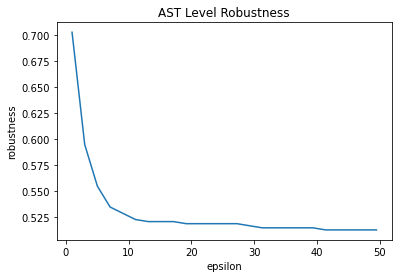

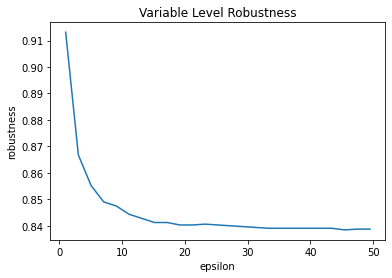

In [20]:
import matplotlib.pyplot as plt

plt.plot(epsilons[:25], ast_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness")
plt.title("AST Level Robustness")
plt.show()

plt.plot(epsilons[:25], var_performances)
plt.xlabel("epsilon")
plt.ylabel("robustness")
plt.title("Variable Level Robustness")
plt.show()

In [17]:
len(var_performances)

25

In [23]:
ast_performances[:-1]

[0.7025948103792415,
 0.5948103792415169,
 0.5548902195608783,
 0.5349301397205588,
 0.5289421157684631,
 0.5229540918163673,
 0.5209580838323353,
 0.5209580838323353,
 0.5209580838323353,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5189620758483033,
 0.5169660678642715,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5149700598802396,
 0.5129740518962076,
 0.5129740518962076,
 0.5129740518962076,
 0.5129740518962076]

In [22]:
var_performances

[0.9131382316313823,
 0.8667496886674969,
 0.8552303860523038,
 0.8490037359900373,
 0.8474470734744708,
 0.8443337484433375,
 0.8427770859277709,
 0.8412204234122043,
 0.8412204234122043,
 0.8402864259028643,
 0.8402864259028643,
 0.8405977584059776,
 0.8402864259028643,
 0.839975093399751,
 0.8396637608966376,
 0.8393524283935243,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.839041095890411,
 0.8384184308841843,
 0.8387297633872977,
 0.8387297633872977]

In [1]:
def ci(x, z, n):
    r = z * ( (x * (1 - x)) / n)**0.5
    return round(x, 3), round(r, 3), round(x-r, 3), round(x+r, 3)

In [4]:
print(ci(0.403, 1.96, 10401))
print(ci(0.327, 1.96, 10401))
print(ci(0.267, 1.96, 10401))
print(ci(0.248, 1.96, 10401))
print(ci(0.222, 1.96, 10401))
print(ci(0.206, 1.96, 10401))


(0.403, 0.009, 0.394, 0.412)
(0.327, 0.009, 0.318, 0.336)
(0.267, 0.009, 0.258, 0.276)
(0.248, 0.008, 0.24, 0.256)
(0.222, 0.008, 0.214, 0.23)
(0.206, 0.008, 0.198, 0.214)


In [5]:
print(ci(0.981, 1.96, 10401))
print(ci(0.970, 1.96, 10401))

(0.981, 0.003, 0.978, 0.984)
(0.97, 0.003, 0.967, 0.973)


In [9]:
print(ci(0.567, 1.96, 10401))

(0.567, 0.01, 0.557, 0.577)
